## FFT/ Periodogram/ Spectral Analysis

In [2]:
import h5py
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pytz
from numpy import fft

In [3]:
f = h5py.File('radial_wind_measurements_simone.h5', 'r') # Opening real wind data as a read only file

In [4]:
# Adding [:] at the end of each dataset to have it treated as an array 
noise = f['alpha_norm'][:]
braggs = f['braggs'][:] # 3-D Bragg vector 'k'
dops = f['dops'][:] # Doppler frequency shift 'f'
alts = f['heights'][:]
lats = f['lats'][:] # Degrees, km, seconds
lons = f['lons'][:] # Degrees, km, seconds
ts = f['t'][:]

In [5]:
t0 = int(1541376000.0)

In [6]:
with h5py.File('../simulated_winds_germany.h5', 'r') as winds: # Opening simulated wind data from Interpolation notebook as read only
    xsim = winds['x'][:] # Longitude (8-17)
    ysim = winds['y'][:] # Latitude (49-57)
    zsim = winds['z'][:] # Altitudes (82,84,86,88,90,92,94,96,98)
    u3dsim = winds['u3d'][:]
    v3dsim = winds['v3d'][:]

In [7]:
alt_window_idx = (alts >= 82) & (alts <= 98) # Pulling needed altitudes from real data to do synthetic interpolation

In [8]:
noise = noise[alt_window_idx]
braggs = braggs[alt_window_idx]
dops = dops[alt_window_idx]
alts = alts[alt_window_idx]
lats = lats[alt_window_idx]
lons = lons[alt_window_idx]
ts = ts[alt_window_idx]

In [9]:
# Importing simulated data created in Interpolation notebook
from scipy.interpolate import RegularGridInterpolator
uinterp = RegularGridInterpolator((xsim,ysim,zsim),u3dsim)
vinterp = RegularGridInterpolator((xsim,ysim,zsim),v3dsim)

In [10]:
# Creating new u and v values 
meas_locs = np.stack((lons, lats, alts), axis=-1)
u = uinterp(meas_locs)
v = vinterp(meas_locs)

In [11]:
t_step = 1800/2  # seconds
t_window = 3600/2 # seconds 
z_step = 1/2  # km
z_window = 2/2  # km

t_idx = np.arange(t0, t0 + 24*60*60, t_step) # 24*60*60 seconds in 24 hours
z_idx = np.arange(82, 98, z_step)
u_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)
v_mean = np.zeros((len(z_idx),len(t_idx)), dtype = np.float_)

for k_t, t_start in enumerate(t_idx): 
    t_end = t_start + t_window

    # select the data within [t_start, t_end]
    time_window_idx = (ts >= t_start) & (ts <= t_end)

    for k_z, z_start in enumerate(z_idx):
        z_end = z_start + z_window
            
        # select the time-windowed data within [z_start, z_end]
        altitude_window_idx = (alts >= z_start) & (alts <= z_end)
            
        window_idx = time_window_idx & altitude_window_idx
        braggs_subset = braggs[window_idx]
        dops_subset = dops[window_idx]

        # do the mean wind calculation
        x = np.linalg.lstsq(braggs_subset[:,:-1]/(2*np.pi), dops_subset, rcond=None)[0]
        u_mean[k_z, k_t] = x[0]
        v_mean[k_z, k_t] = x[1]

In [12]:
tz = pytz.timezone('Europe/Berlin') # Data taken over Germany thus we need that timezone
t_plot = [datetime.fromtimestamp(tt, tz=tz) for tt in t_idx] 
T,Z = np.meshgrid(t_plot, z_idx) # We want to directly plot altitude and time on axes through pcolormesh but to do this you need to make x and y 2d arrays

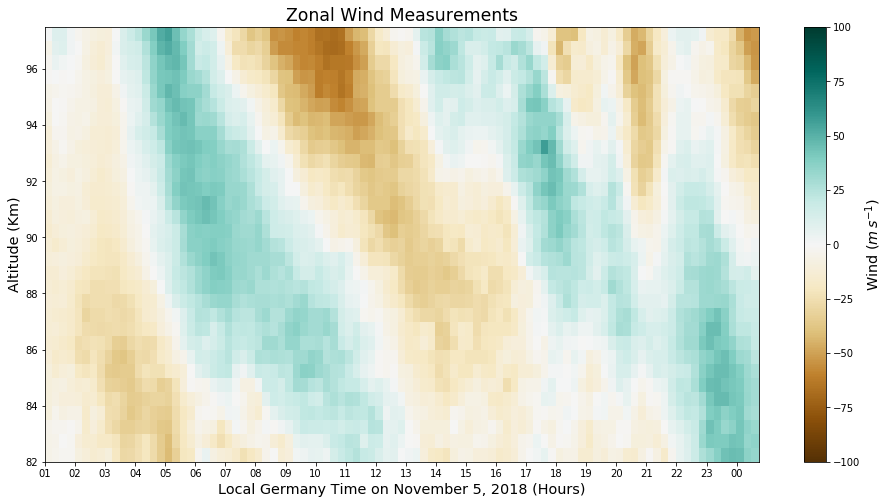

In [13]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, u_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

In [14]:
#You want to pick the altitude index manually (i.e. choose 0) then use it to get the right row from u_mean. So u_mean has a shape (n_alt, n_t), z_idx has a shape (n_alt,), and t_idx has a shape (n_t,). You choose to select the altitude with index 0, so that gives you:
#u_mean[0, :], which now has a shape of (n_t,) since you're picking off the first row
#z_idx[0], which is just the value of 82.0

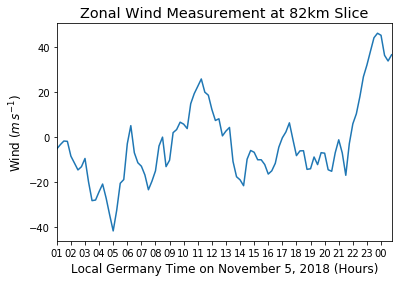

In [15]:
fig = plt.figure()

plt.plot(t_plot, u_mean[0, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurement at 82km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

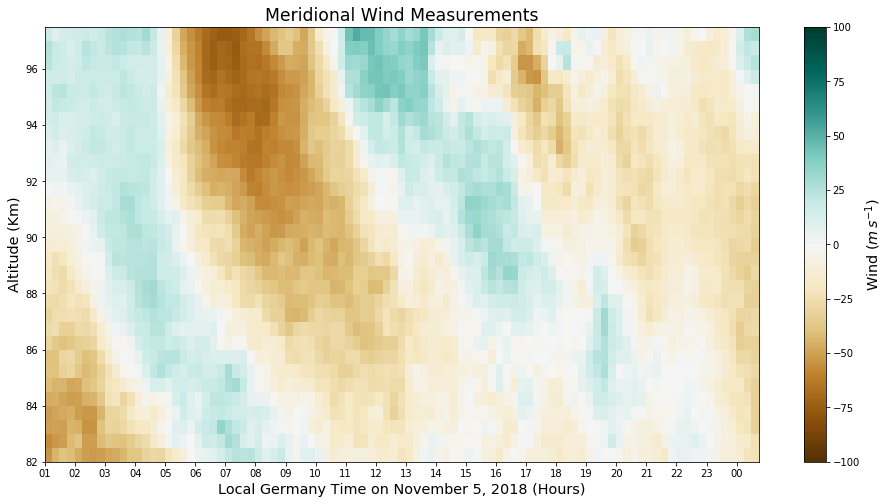

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

cmap = cm.get_cmap('BrBG')

cs = plt.pcolormesh(T, Z, v_mean, cmap = cmap, vmin = -100, vmax = 100)

# We want hours to be plotted on the x-axis
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurements', size = 'xx-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'x-large')
plt.ylabel('Altitude (Km)', size = 'x-large')

cb = plt.colorbar(cs, orientation = 'vertical')
cb.set_label(r'Wind ($m\/s^{-1}$)', size = 'x-large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)

plt.show()

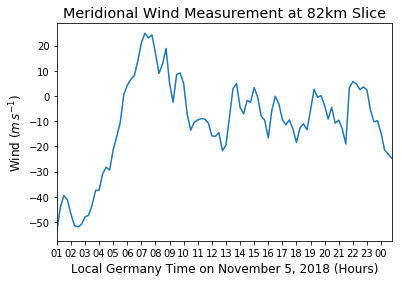

In [17]:
fig = plt.figure()

plt.plot(t_plot, v_mean[0, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurement at 82km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

In [18]:
z_idx[4]

84.0

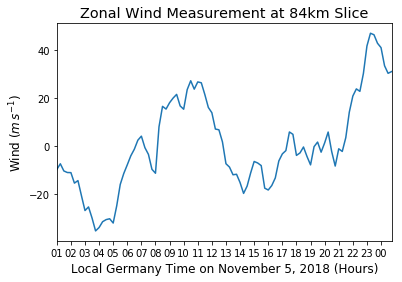

In [19]:
fig = plt.figure()

plt.plot(t_plot, u_mean[4, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurement at 84km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

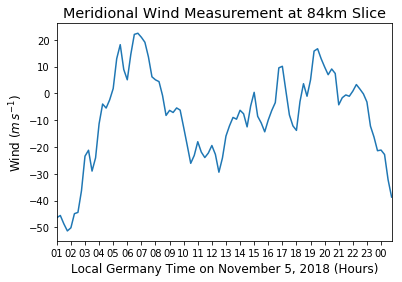

In [20]:
fig = plt.figure()

plt.plot(t_plot, v_mean[4, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurement at 84km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

In [21]:
z_idx[8]

86.0

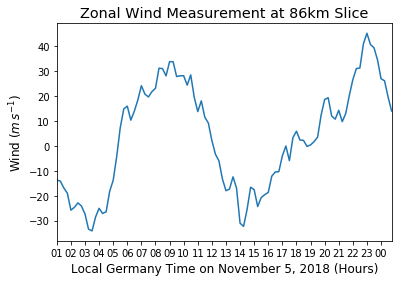

In [22]:
fig = plt.figure()

plt.plot(t_plot, u_mean[8, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurement at 86km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

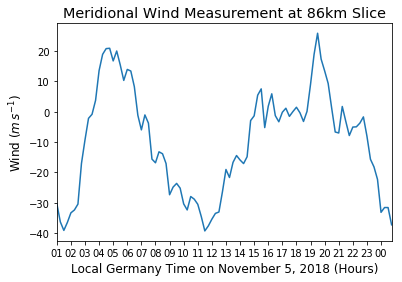

In [23]:
fig = plt.figure()

plt.plot(t_plot, v_mean[8, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurement at 86km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

In [24]:
z_idx[12]

88.0

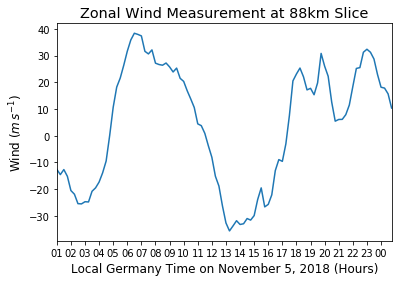

In [25]:
fig = plt.figure()

plt.plot(t_plot, u_mean[12, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurement at 88km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

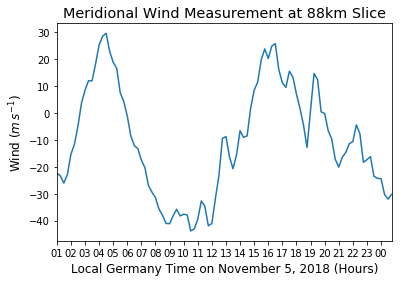

In [26]:
fig = plt.figure()

plt.plot(t_plot, v_mean[12, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurement at 88km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

In [27]:
z_idx[16]

90.0

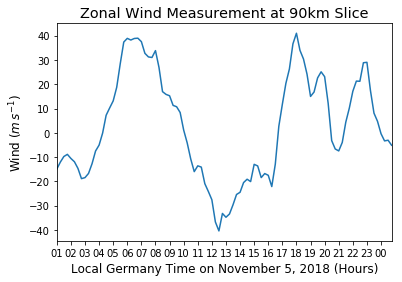

In [28]:
fig = plt.figure()

plt.plot(t_plot, u_mean[16, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurement at 90km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

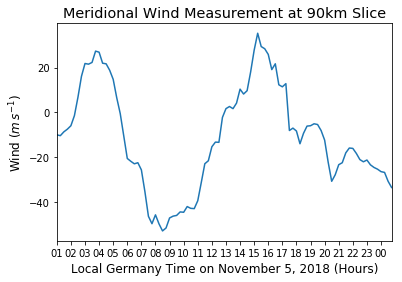

In [29]:
fig = plt.figure()

plt.plot(t_plot, v_mean[16, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurement at 90km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

In [30]:
z_idx[20]

92.0

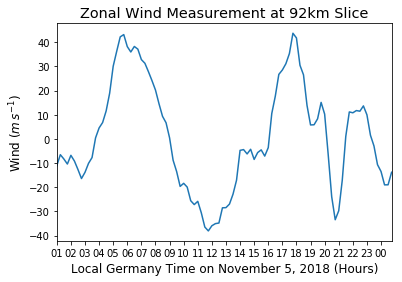

In [31]:
fig = plt.figure()

plt.plot(t_plot, u_mean[20, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurement at 92km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

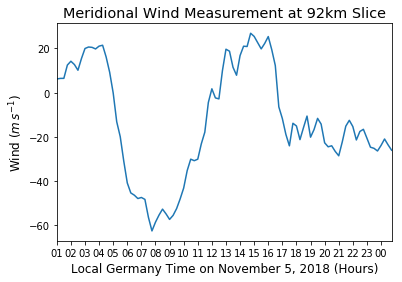

In [32]:
fig = plt.figure()

plt.plot(t_plot, v_mean[20, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurement at 92km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

In [33]:
z_idx[24]

94.0

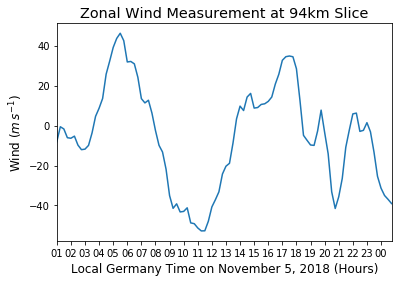

In [34]:
fig = plt.figure()

plt.plot(t_plot, u_mean[24, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurement at 94km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

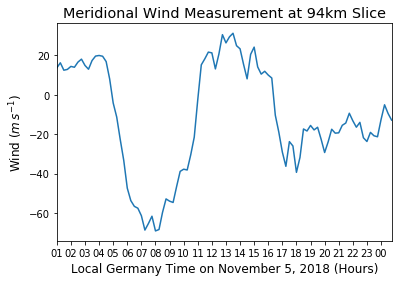

In [35]:
fig = plt.figure()

plt.plot(t_plot, v_mean[24, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurement at 94km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

In [36]:
z_idx[28]

96.0

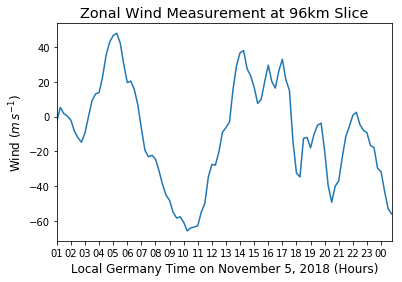

In [37]:
fig = plt.figure()

plt.plot(t_plot, u_mean[28, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Zonal Wind Measurement at 96km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

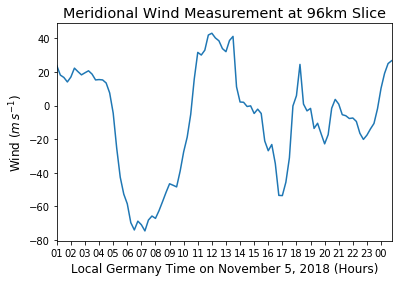

In [38]:
fig = plt.figure()

plt.plot(t_plot, v_mean[28, :])

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

plt.title('Meridional Wind Measurement at 96km Slice', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.ylabel('Wind ($m\/s^{-1}$)', size = 'large')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.show()

## FFT

In [39]:
#For doing an FFT, you'll then be analyzing the 1-D array of u_mean[, :] and v_mean[, :].

In [40]:
np.fft.fft(u_mean[0, :])

array([-268.12468532+0.00000000e+00j,   80.76398302+2.16486243e+02j,
        535.30721324+6.88187200e+02j,  344.21471259+1.37212945e+02j,
         99.10274619+5.38059978e+02j,   35.61880043+3.32939756e+01j,
       -164.54258848+8.54642582e+01j, -134.90654317+1.23525602e+02j,
       -149.54713072+1.44099226e+02j,   60.34566973-1.16746629e+01j,
         60.73514589-2.06670889e+01j, -171.6861805 -1.35467920e+01j,
          2.86799386+4.22889709e+01j,  -30.28855099+1.29183033e+02j,
         62.68829917-6.29349139e+00j,  -55.07618724-2.04915840e+01j,
        -11.15797327-2.30200666e+01j,  -24.28327276-3.36923179e+01j,
        -43.26487073-3.92773649e+00j,  -11.15125447+1.35352235e+02j,
        -35.09779157+3.35976485e+01j,  -69.83127819+3.88984996e+01j,
         -2.42735617+3.89462191e+01j,   60.06716002+1.12122944e+01j,
        -10.21605503-1.78137420e+00j,  -24.63532358+4.62157576e+01j,
        -19.6163627 +6.69874287e+01j,  -54.11467216+3.42655911e+01j,
        -20.97398807-3.25652550e+0

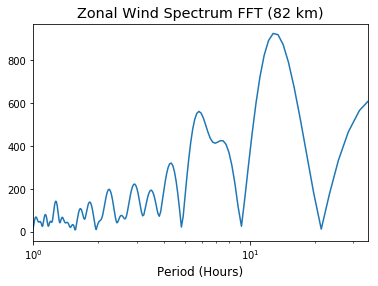

In [41]:
nfft = 1024
sp = np.fft.rfft(u_mean[0, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Zonal Wind Spectrum FFT (82 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35) # allows us to see up to 12 hours
plt.show()

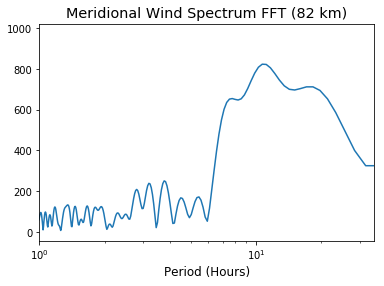

In [42]:
nfft = 1024
sp = np.fft.rfft(v_mean[0, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Meridional Wind Spectrum FFT (82 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

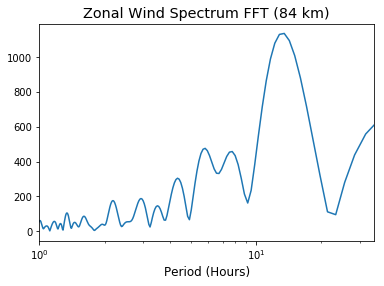

In [43]:
nfft = 1024
sp = np.fft.rfft(u_mean[4, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Zonal Wind Spectrum FFT (84 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

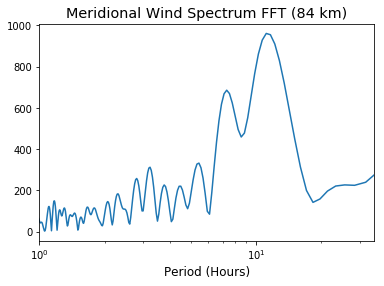

In [44]:
nfft = 1024
sp = np.fft.rfft(v_mean[4, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Meridional Wind Spectrum FFT (84 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

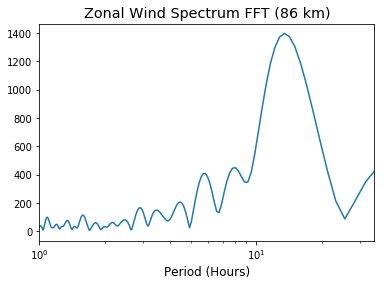

In [45]:
nfft = 1024
sp = np.fft.rfft(u_mean[8, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Zonal Wind Spectrum FFT (86 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

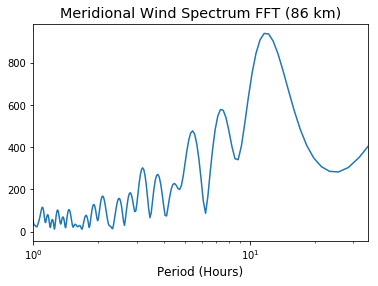

In [46]:
nfft = 1024
sp = np.fft.rfft(v_mean[8, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Meridional Wind Spectrum FFT (86 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

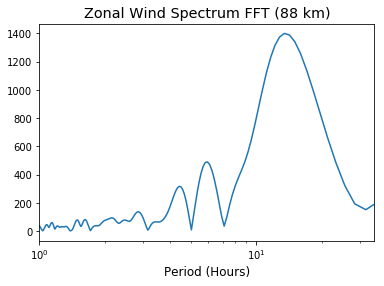

In [47]:
nfft = 1024
sp = np.fft.rfft(u_mean[12, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Zonal Wind Spectrum FFT (88 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

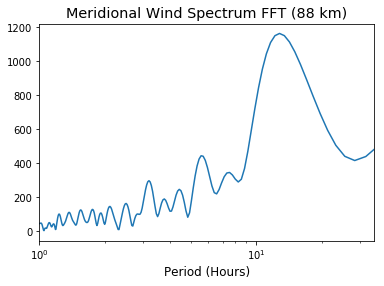

In [48]:
nfft = 1024
sp = np.fft.rfft(v_mean[12, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Meridional Wind Spectrum FFT (88 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

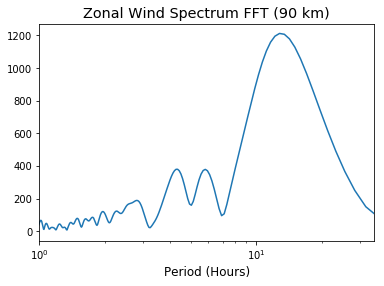

In [49]:
nfft = 1024
sp = np.fft.rfft(u_mean[16, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Zonal Wind Spectrum FFT (90 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

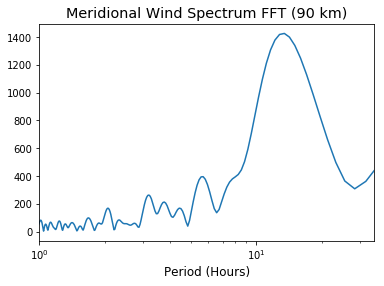

In [50]:
nfft = 1024
sp = np.fft.rfft(v_mean[16, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Meridional Wind Spectrum FFT (90 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

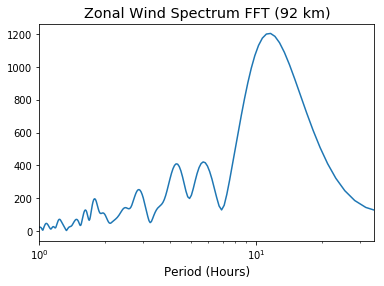

In [51]:
nfft = 1024
sp = np.fft.rfft(u_mean[20, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Zonal Wind Spectrum FFT (92 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

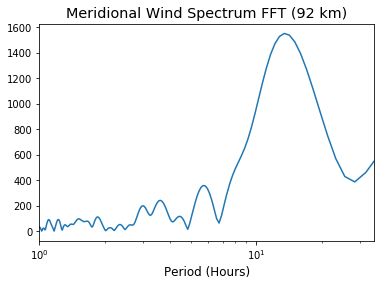

In [52]:
nfft = 1024
sp = np.fft.rfft(v_mean[20, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Meridional Wind Spectrum FFT (92 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours
plt.xlim(1,35)
plt.show()

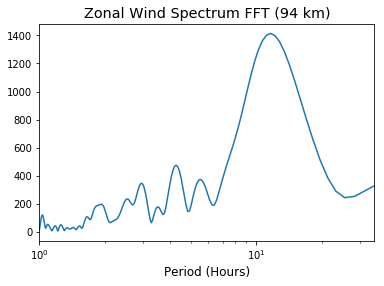

In [53]:
nfft = 1024
sp = np.fft.rfft(u_mean[24, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Zonal Wind Spectrum FFT (94 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

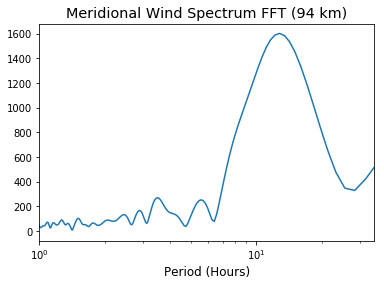

In [54]:
nfft = 1024
sp = np.fft.rfft(v_mean[24, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Meridional Wind Spectrum FFT (94 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

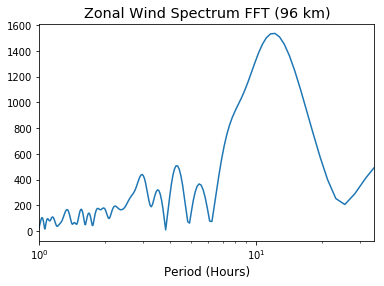

In [55]:
nfft = 1024
sp = np.fft.rfft(u_mean[28, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Zonal Wind Spectrum FFT (96 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

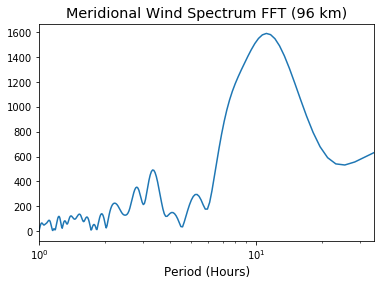

In [56]:
nfft = 1024
sp = np.fft.rfft(v_mean[28, :], nfft)
freq = np.fft.rfftfreq(nfft, t_idx[1] - t_idx[0])
period = 1 / freq[1:] / 3600
plt.title('Meridional Wind Spectrum FFT (96 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period, np.abs(sp[1:])) #x axis is in hours 
plt.xlim(1,35)
plt.show()

## Begin Periodogram

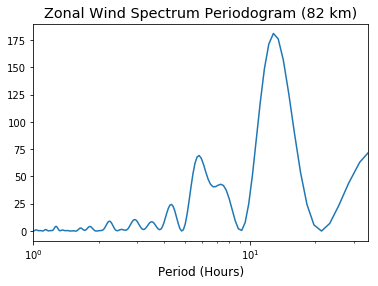

In [57]:
from scipy import signal
f, a = signal.periodogram(u_mean[0, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Zonal Wind Spectrum Periodogram (82 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

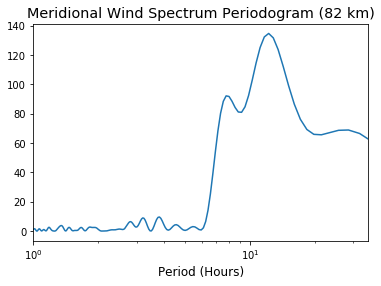

In [58]:
from scipy import signal
f, a = signal.periodogram(v_mean[0, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Meridional Wind Spectrum Periodogram (82 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

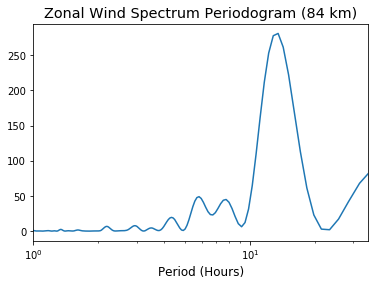

In [59]:
from scipy import signal
f, a = signal.periodogram(u_mean[4, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Zonal Wind Spectrum Periodogram (84 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

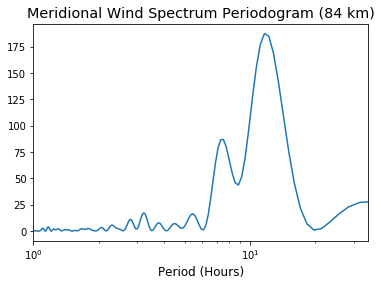

In [60]:
from scipy import signal
f, a = signal.periodogram(v_mean[4, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Meridional Wind Spectrum Periodogram (84 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

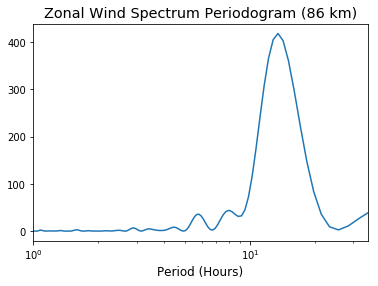

In [61]:
from scipy import signal
f, a = signal.periodogram(u_mean[8, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Zonal Wind Spectrum Periodogram (86 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

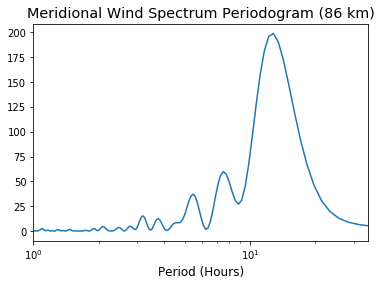

In [62]:
from scipy import signal
f, a = signal.periodogram(v_mean[8, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Meridional Wind Spectrum Periodogram (86 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

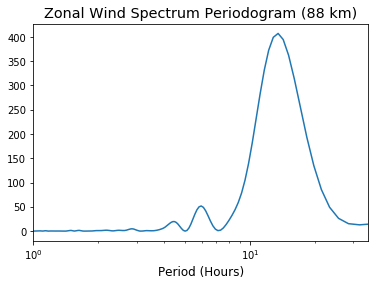

In [63]:
from scipy import signal
f, a = signal.periodogram(u_mean[12, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Zonal Wind Spectrum Periodogram (88 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

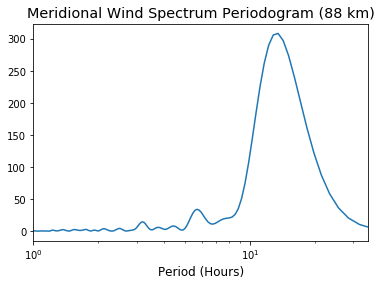

In [64]:
from scipy import signal
f, a = signal.periodogram(v_mean[12, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Meridional Wind Spectrum Periodogram (88 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

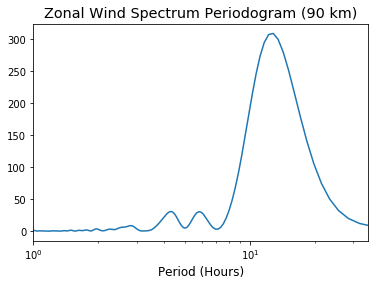

In [65]:
from scipy import signal
f, a = signal.periodogram(u_mean[16, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Zonal Wind Spectrum Periodogram (90 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

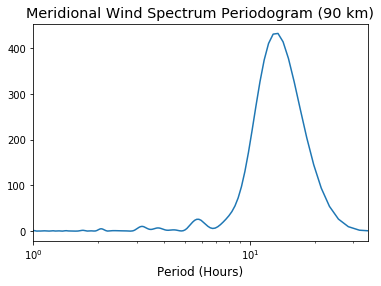

In [66]:
from scipy import signal
f, a = signal.periodogram(v_mean[16, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Meridional Wind Spectrum Periodogram (90 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

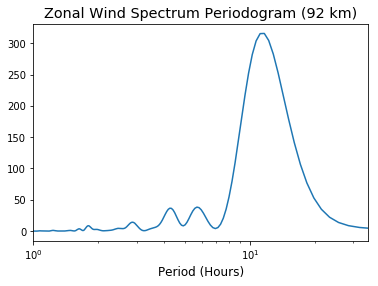

In [67]:
from scipy import signal
f, a = signal.periodogram(u_mean[20, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Zonal Wind Spectrum Periodogram (92 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

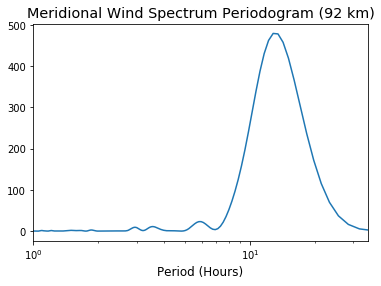

In [68]:
from scipy import signal
f, a = signal.periodogram(v_mean[20, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Meridional Wind Spectrum Periodogram (92 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

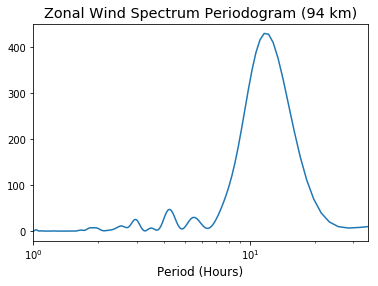

In [69]:
from scipy import signal
f, a = signal.periodogram(u_mean[24, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Zonal Wind Spectrum Periodogram (94 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

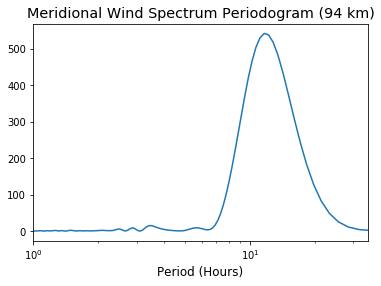

In [70]:
from scipy import signal
f, a = signal.periodogram(v_mean[24, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Meridional Wind Spectrum Periodogram (94 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

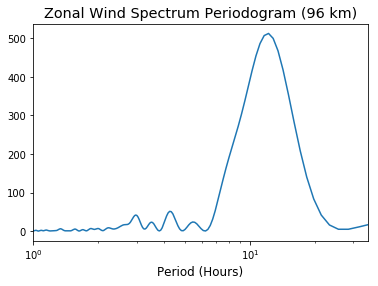

In [71]:
from scipy import signal
f, a = signal.periodogram(u_mean[28, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Zonal Wind Spectrum Periodogram (96 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

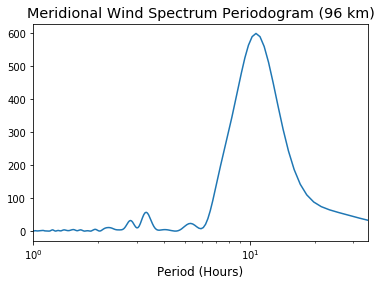

In [72]:
from scipy import signal
f, a = signal.periodogram(v_mean[28, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period = 1 / f[1:] / 3600
plt.title('Meridional Wind Spectrum Periodogram (96 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')
plt.semilogx(period,a[1:])
plt.xlim(1,35)
plt.show()

## Exploring CWT - Doesn't Work Well

In [73]:
# The "width" for the CWT is indeed in number of samples. So it makes no sense for the value of the width to be larger than the number of samples in the array for which you are doing the CWT. You can use something like:

# widths = np.linspace(1, len(t_idx), 400)
# widths_hours = widths * (t_idx[1] - t_idx[0]) / 3600  # width of the wavelet in hours

# Then you would use widths for the CWT calculation but widths_hours for plotting the image.

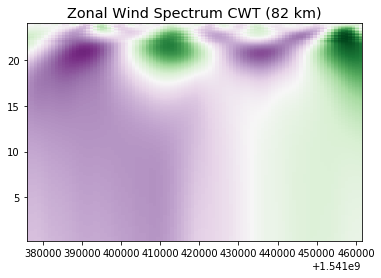

In [74]:
from scipy import signal

widths = np.linspace(1, len(t_idx), 400)
widths_hours = widths * (t_idx[1] - t_idx[0]) / 3600  # width of the wavelet in hours

cwtmatr = signal.cwt(u_mean[0, :], signal.ricker, widths)

plt.title('Zonal Wind Spectrum CWT (82 km)', size = 'x-large')
plt.imshow(cwtmatr, cmap='PRGn', extent=[t_idx[0], t_idx[-1], widths_hours[0], widths_hours[-1]], aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

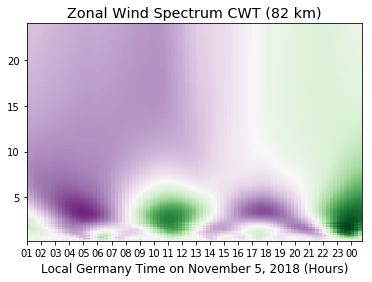

In [75]:
from scipy import signal

main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

widths = np.linspace(1, len(t_idx), 400)
widths_hours = widths * (t_idx[1] - t_idx[0]) / 3600  # width of the wavelet in hours

cwtmatr = signal.cwt(u_mean[0, :], signal.ricker, widths)

X, Y = np.meshgrid(t_plot, widths_hours, indexing='ij')

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Zonal Wind Spectrum CWT (82 km)', size = 'x-large')
plt.xlabel('Local Germany Time on November 5, 2018 (Hours)', size = 'large')
plt.pcolormesh(X, Y, cwtmatr.T, cmap='PRGn', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

In [76]:
print(len(t_idx))

96


In [77]:
cwtmatr.shape
X.shape

(96, 400)

## 82km Smoothing

In [101]:
# To do the smoothing, first design a moving average window:

import scipy as sp
import scipy.signal as ss

period_cutoff = 4*3600  # seconds
win = ss.firwin(len(t_idx), 1./period_cutoff, window='hann', fs=1./(t_idx[1] - t_idx[0]))

# Then average the data by correlating with the window:

u_smooth = ss.correlate(u_mean[0, :], win, mode='same')
v_smooth = ss.correlate(v_mean[0, :], win, mode='same')

# Can change the period cutoff to affect how smooth you want the result to be. 
#Plot u_smooth and u_mean[IDX, :] together to compare, and then you can subtract them to get the differential wind.

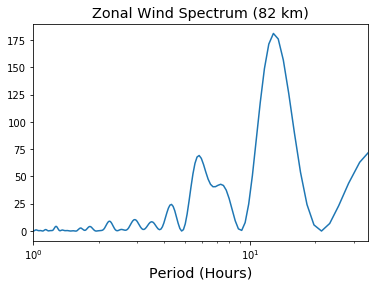

In [102]:
f, a = ss.periodogram(u_mean[0, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[0, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind Spectrum (82 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_mean,a[1:])

plt.xlim(1,35)
plt.savefig('zonal_wind_spectrum_82.png', dpi=200, bbox_inches='tight', pad_inches=0.025)

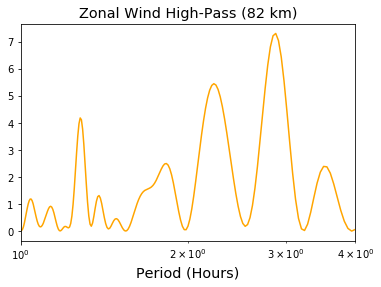

In [103]:
f, a = ss.periodogram(u_mean[0, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[0, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind High-Pass (82 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)
plt.savefig('zonal_wind_highpass_82.png', dpi=200, bbox_inches='tight', pad_inches=0.025)

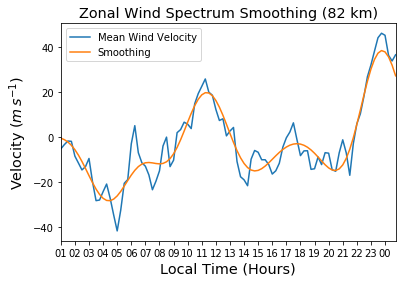

In [104]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.plot(t_plot, u_mean[0, :], label= 'Mean Wind Velocity')
plt.plot(t_plot, u_smooth, label='Smoothing')

plt.title('Zonal Wind Spectrum Smoothing (82 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.legend(loc=2)

plt.savefig('zonal_smoothclose_82.png', dpi=200, bbox_inches='tight', pad_inches=0.025)

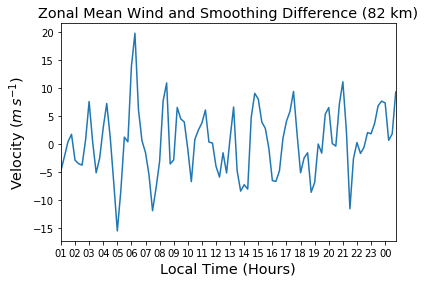

In [105]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

u_diff = u_mean[0, :] - u_smooth
plt.plot(t_plot, u_diff)

plt.title('Zonal Mean Wind and Smoothing Difference (82 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.savefig('zonal_smoothdiff_82.png', dpi=200, bbox_inches='tight', pad_inches=0.025)

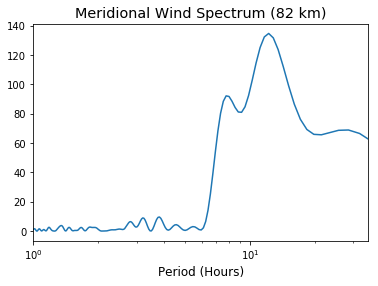

In [106]:
f, a = ss.periodogram(v_mean[0, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[0, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind Spectrum (82 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')


plt.semilogx(period,a[1:])

plt.xlim(1,35)
plt.show()

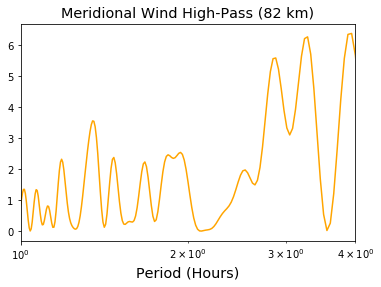

In [107]:
f, a = ss.periodogram(v_mean[0, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = v_mean[0, :] - u_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind High-Pass (82 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)
plt.savefig('zonal_wind_highpass_82.png', dpi=200, bbox_inches='tight', pad_inches=0.025)

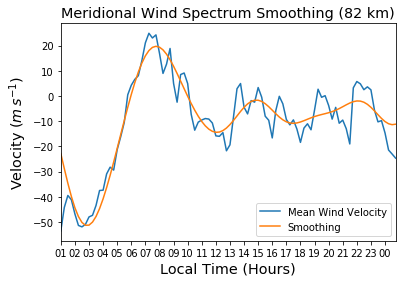

In [108]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Meridional Wind Spectrum Smoothing (82 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, v_mean[0, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, v_smooth, label = 'Smoothing')

plt.legend(loc=4)

Text(0, 0.5, 'Velocity ($m\\/s^{-1}$)')

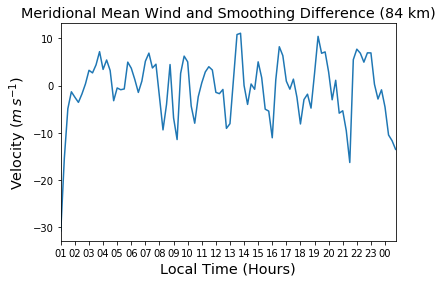

In [109]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

v_diff = v_mean[0, :] - v_smooth
plt.plot(t_plot, v_diff)

plt.title('Meridional Mean Wind and Smoothing Difference (82 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

## 84 km Smoothing

In [110]:
period_cutoff = 6.5*3600  # seconds
win = ss.firwin(len(t_idx), 1./period_cutoff, window='hann', fs=1./(t_idx[1] - t_idx[0]))

u_smooth = ss.correlate(u_mean[4, :], win, mode='same')
v_smooth = ss.correlate(v_mean[4, :], win, mode='same')

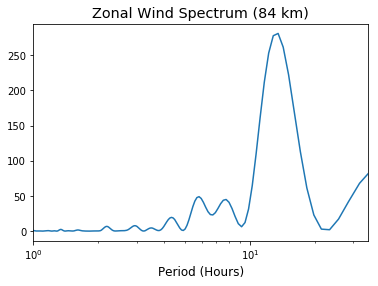

In [111]:
f, a = ss.periodogram(u_mean[4, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[4, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind Spectrum (84 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')

plt.semilogx(period_mean,a[1:])

plt.xlim(1,35)
plt.show()

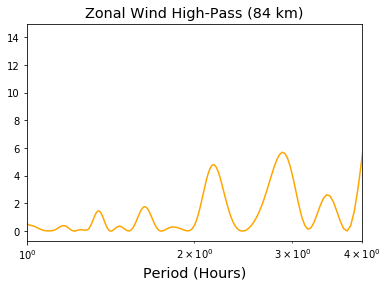

In [112]:
f, a = ss.periodogram(u_mean[4, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[4, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind High-Pass (84 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

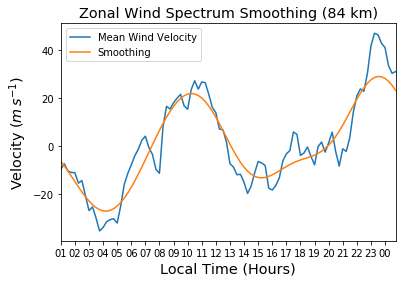

In [113]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.plot(t_plot, u_mean[4, :], label= 'Mean Wind Velocity')
plt.plot(t_plot, u_smooth, label='Smoothing')

plt.title('Zonal Wind Spectrum Smoothing (84 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.legend(loc=2)

Text(0, 0.5, 'Velocity ($m\\/s^{-1}$)')

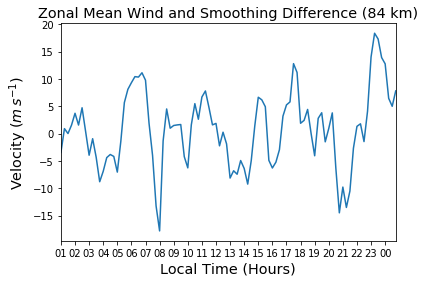

In [114]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

u_diff = u_mean[4, :] - u_smooth
plt.plot(t_plot, u_diff)

plt.title('Zonal Mean Wind and Smoothing Difference (84 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

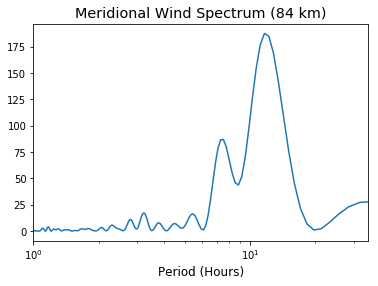

In [115]:
f, a = ss.periodogram(v_mean[4, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[4, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind Spectrum (84 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')


plt.semilogx(period,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

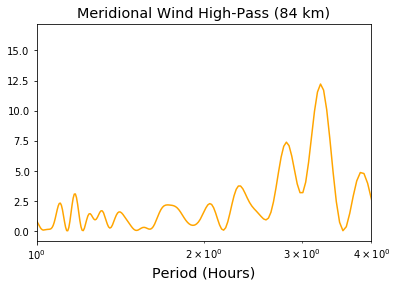

In [128]:
f, a = ss.periodogram(v_mean[4, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[4, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind High-Pass (84 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

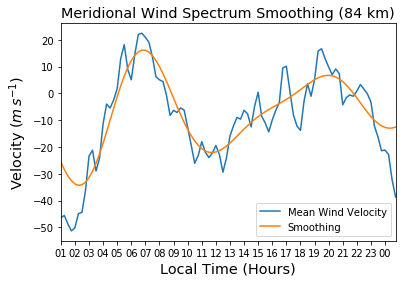

In [117]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Meridional Wind Spectrum Smoothing (84 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, v_mean[4, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, v_smooth, label = 'Smoothing')

plt.legend(loc=4)

[]

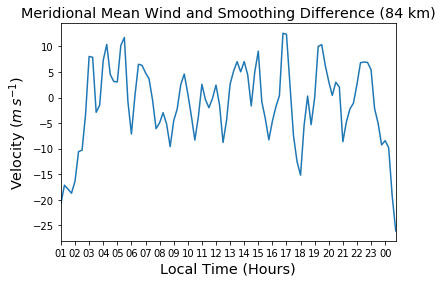

In [119]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

v_diff = v_mean[4, :] - v_smooth
plt.plot(t_plot, v_diff)

plt.title('Meridional Mean Wind and Smoothing Difference (84 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot()

## 86 km Smoothing

In [94]:
period_cutoff = 7*3600  # seconds
win = ss.firwin(len(t_idx), 1./period_cutoff, window='hann', fs=1./(t_idx[1] - t_idx[0]))

u_smooth = ss.correlate(u_mean[8, :], win, mode='same')
v_smooth = ss.correlate(v_mean[8, :], win, mode='same')

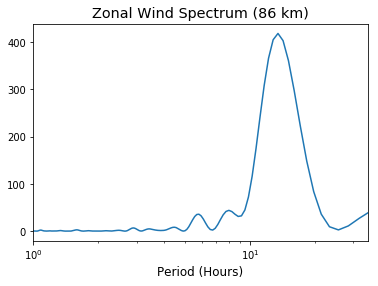

In [120]:
f, a = ss.periodogram(u_mean[8, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[8, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind Spectrum (86 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')

plt.semilogx(period_mean,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

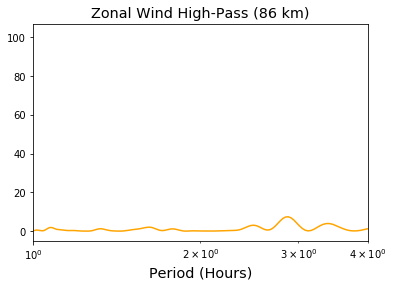

In [122]:
f, a = ss.periodogram(u_mean[8, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[8, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind High-Pass (86 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

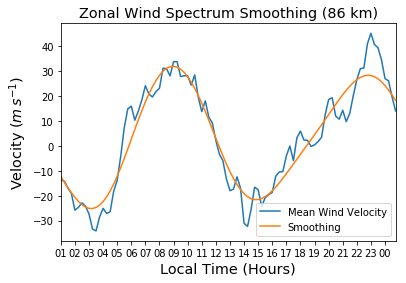

In [136]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Zonal Wind Spectrum Smoothing (86 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, u_mean[8, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, u_smooth, label = 'Smoothing')

plt.legend(loc=4)

Text(0, 0.5, 'Velocity ($m\\/s^{-1}$)')

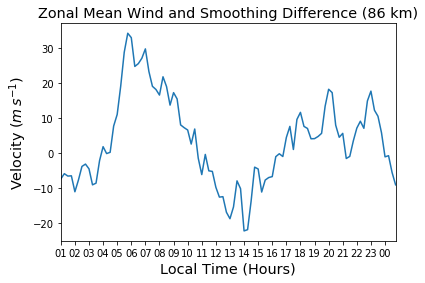

In [124]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

u_diff = u_mean[8, :] - u_smooth
plt.plot(t_plot, u_diff)

plt.title('Zonal Mean Wind and Smoothing Difference (86 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

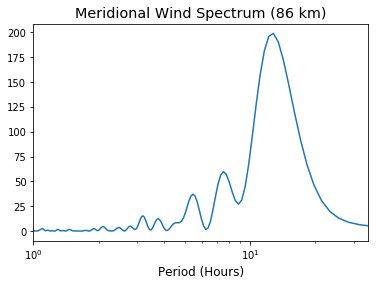

In [125]:
f, a = ss.periodogram(v_mean[8, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[8, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind Spectrum (86 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')

plt.semilogx(period,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

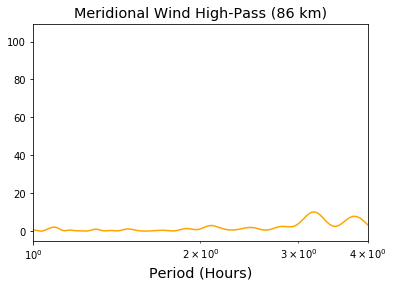

In [127]:
f, a = ss.periodogram(v_mean[8, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[8, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind High-Pass (86 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

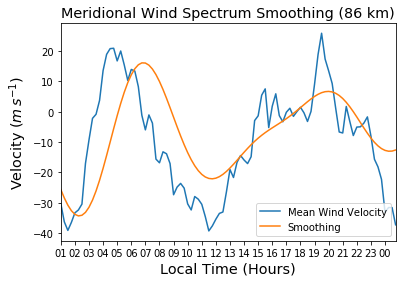

In [132]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Meridional Wind Spectrum Smoothing (86 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, v_mean[8, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, v_smooth, label = 'Smoothing')

plt.legend(loc=4)

[]

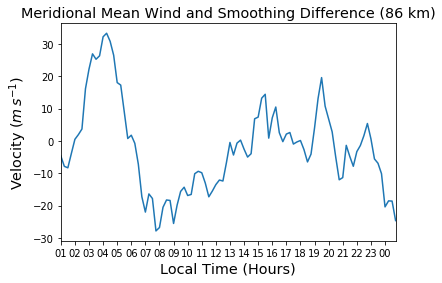

In [131]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

v_diff = v_mean[8, :] - v_smooth
plt.plot(t_plot, v_diff)

plt.title('Meridional Mean Wind and Smoothing Difference (86 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot()

## 88 km Smoothing

In [133]:
period_cutoff = 7*3600  # seconds
win = ss.firwin(len(t_idx), 1./period_cutoff, window='hann', fs=1./(t_idx[1] - t_idx[0]))

u_smooth = ss.correlate(u_mean[8, :], win, mode='same')
v_smooth = ss.correlate(v_mean[8, :], win, mode='same')

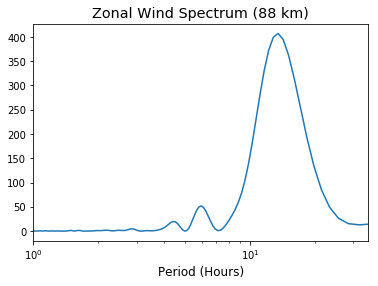

In [134]:
f, a = ss.periodogram(u_mean[12, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[12, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind Spectrum (88 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')

plt.semilogx(period_mean,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

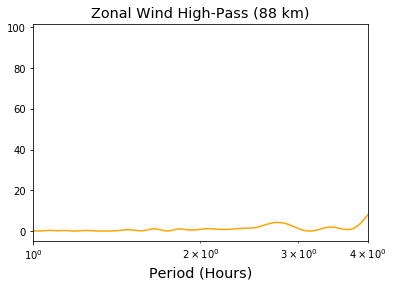

In [135]:
f, a = ss.periodogram(u_mean[12, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[12, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind High-Pass (88 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

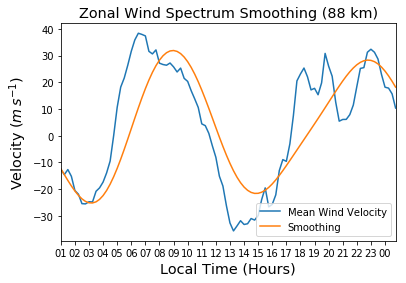

In [137]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Zonal Wind Spectrum Smoothing (88 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, u_mean[12, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, u_smooth, label = 'Smoothing')

plt.legend(loc=4)

Text(0, 0.5, 'Velocity ($m\\/s^{-1}$)')

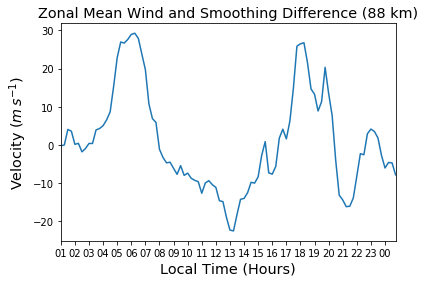

In [138]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

u_diff = u_mean[12, :] - u_smooth
plt.plot(t_plot, u_diff)

plt.title('Zonal Mean Wind and Smoothing Difference (88 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

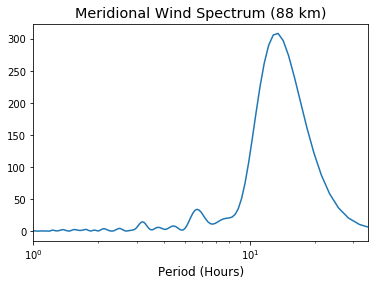

In [139]:
f, a = ss.periodogram(v_mean[12, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[12, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind Spectrum (88 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')

plt.semilogx(period,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

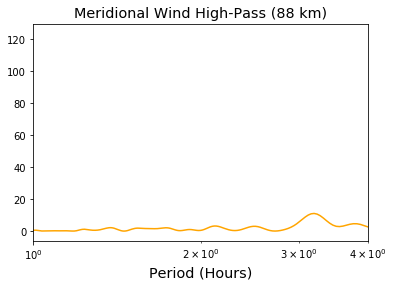

In [140]:
f, a = ss.periodogram(v_mean[12, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[12, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind High-Pass (88 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

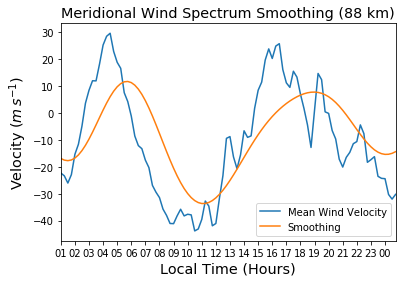

In [141]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Meridional Wind Spectrum Smoothing (88 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, v_mean[12, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, v_smooth, label = 'Smoothing')

plt.legend(loc=4)

[]

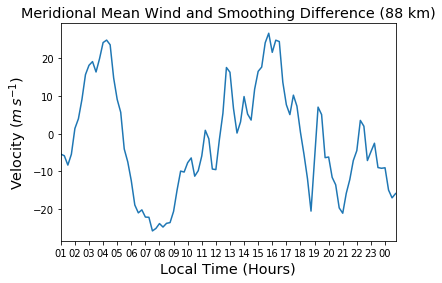

In [142]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

v_diff = v_mean[12, :] - v_smooth
plt.plot(t_plot, v_diff)

plt.title('Meridional Mean Wind and Smoothing Difference (88 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot()

## 90 km Smoothing

In [143]:
period_cutoff = 7*3600  # seconds
win = ss.firwin(len(t_idx), 1./period_cutoff, window='hann', fs=1./(t_idx[1] - t_idx[0]))

u_smooth = ss.correlate(u_mean[16, :], win, mode='same')
v_smooth = ss.correlate(v_mean[16, :], win, mode='same')

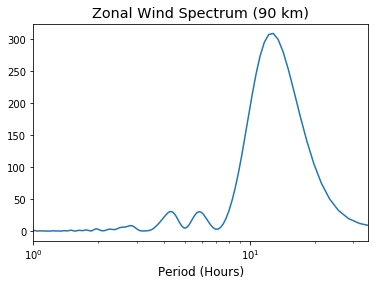

In [144]:
f, a = ss.periodogram(u_mean[16, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[16, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind Spectrum (90 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')

plt.semilogx(period_mean,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

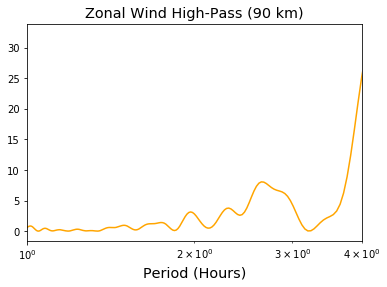

In [145]:
f, a = ss.periodogram(u_mean[16, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[16, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind High-Pass (90 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

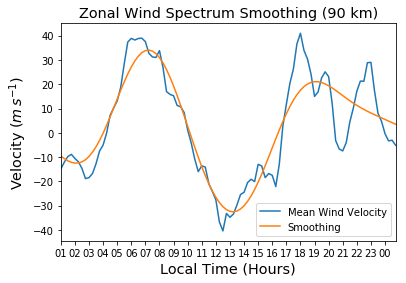

In [146]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Zonal Wind Spectrum Smoothing (90 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, u_mean[16, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, u_smooth, label = 'Smoothing')

plt.legend(loc=4)

Text(0, 0.5, 'Velocity ($m\\/s^{-1}$)')

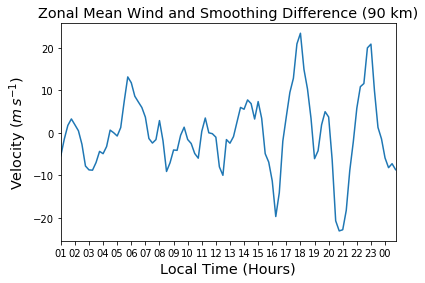

In [147]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

u_diff = u_mean[16, :] - u_smooth
plt.plot(t_plot, u_diff)

plt.title('Zonal Mean Wind and Smoothing Difference (90 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

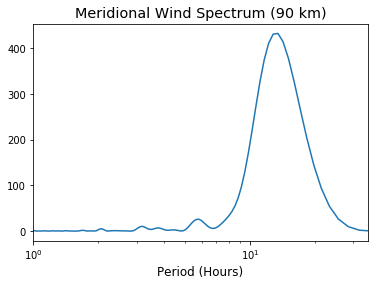

In [148]:
f, a = ss.periodogram(v_mean[16, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[16, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind Spectrum (90 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')

plt.semilogx(period,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

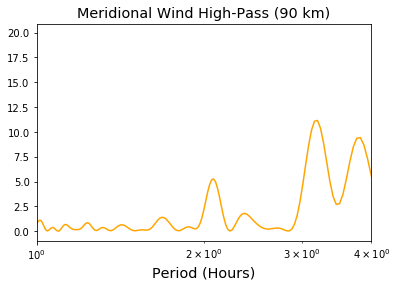

In [149]:
f, a = ss.periodogram(v_mean[16, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[16, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind High-Pass (90 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

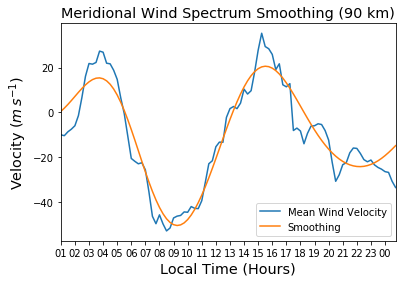

In [150]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Meridional Wind Spectrum Smoothing (90 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, v_mean[16, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, v_smooth, label = 'Smoothing')

plt.legend(loc=4)

[]

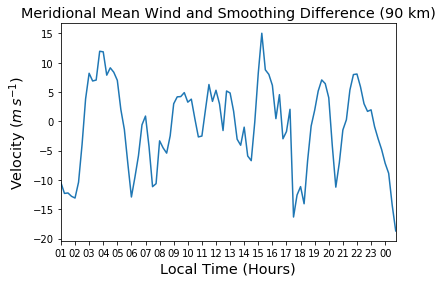

In [151]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

v_diff = v_mean[16, :] - v_smooth
plt.plot(t_plot, v_diff)

plt.title('Meridional Mean Wind and Smoothing Difference (90 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot()

## 92 km Smoothing

In [152]:
period_cutoff = 7*3600  # seconds
win = ss.firwin(len(t_idx), 1./period_cutoff, window='hann', fs=1./(t_idx[1] - t_idx[0]))

u_smooth = ss.correlate(u_mean[20, :], win, mode='same')
v_smooth = ss.correlate(v_mean[20, :], win, mode='same')

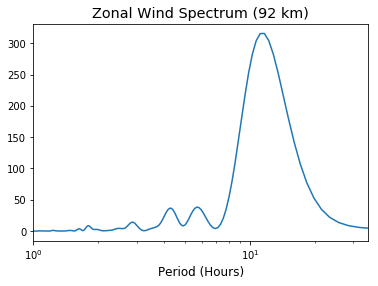

In [153]:
f, a = ss.periodogram(u_mean[20, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[20, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind Spectrum (92 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')

plt.semilogx(period_mean,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

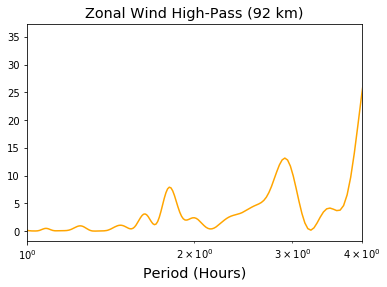

In [154]:
f, a = ss.periodogram(u_mean[20, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[20, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind High-Pass (92 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

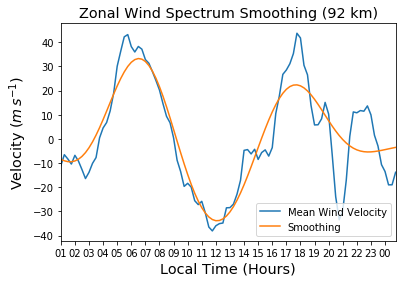

In [155]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Zonal Wind Spectrum Smoothing (92 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, u_mean[20, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, u_smooth, label = 'Smoothing')

plt.legend(loc=4)

Text(0, 0.5, 'Velocity ($m\\/s^{-1}$)')

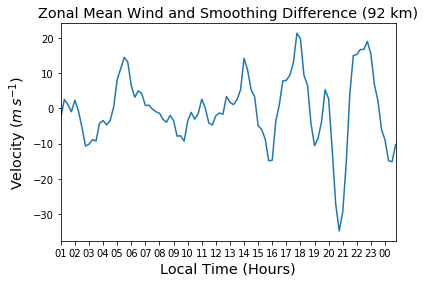

In [156]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

u_diff = u_mean[20, :] - u_smooth
plt.plot(t_plot, u_diff)

plt.title('Zonal Mean Wind and Smoothing Difference (92 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

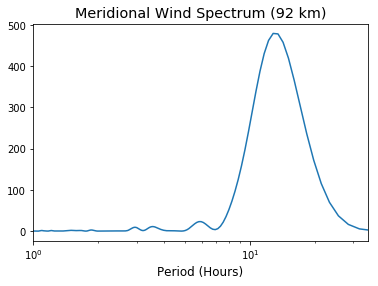

In [157]:
f, a = ss.periodogram(v_mean[20, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[20, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind Spectrum (92 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')


plt.semilogx(period,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

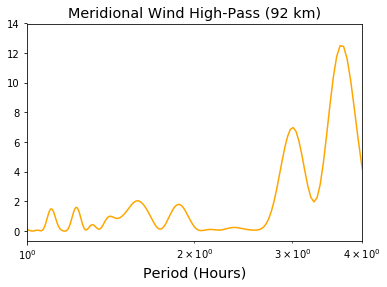

In [158]:
f, a = ss.periodogram(v_mean[20, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[20, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind High-Pass (92 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

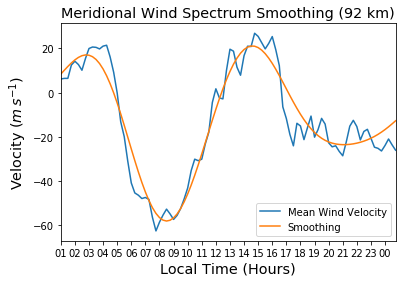

In [159]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Meridional Wind Spectrum Smoothing (92 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, v_mean[20, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, v_smooth, label = 'Smoothing')

plt.legend(loc=4)

[]

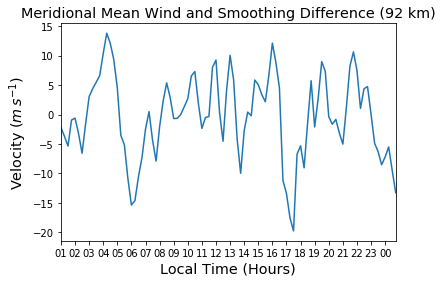

In [160]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

v_diff = v_mean[20, :] - v_smooth
plt.plot(t_plot, v_diff)

plt.title('Meridional Mean Wind and Smoothing Difference (92 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot()

## 94 km Smoothing

In [161]:
period_cutoff = 7*3600  # seconds
win = ss.firwin(len(t_idx), 1./period_cutoff, window='hann', fs=1./(t_idx[1] - t_idx[0]))

u_smooth = ss.correlate(u_mean[24, :], win, mode='same')
v_smooth = ss.correlate(v_mean[24, :], win, mode='same')

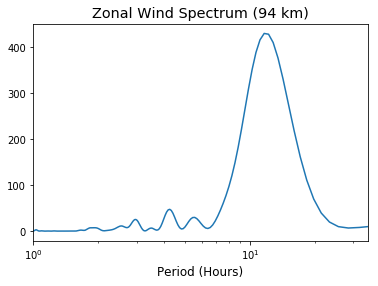

In [162]:
f, a = ss.periodogram(u_mean[24, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[24, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind Spectrum (94 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')

plt.semilogx(period_mean,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

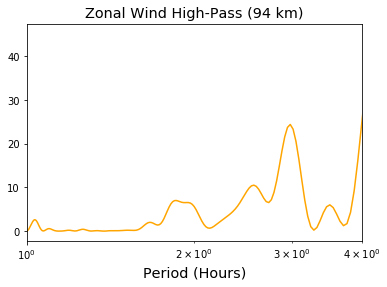

In [163]:
f, a = ss.periodogram(u_mean[24, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[24, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind High-Pass (94 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

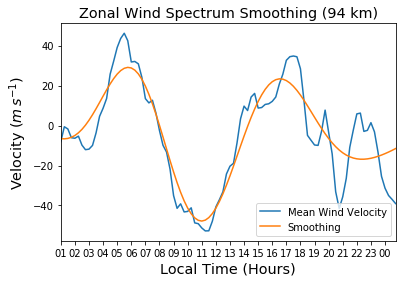

In [164]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Zonal Wind Spectrum Smoothing (94 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, u_mean[24, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, u_smooth, label = 'Smoothing')

plt.legend(loc=4)

Text(0, 0.5, 'Velocity ($m\\/s^{-1}$)')

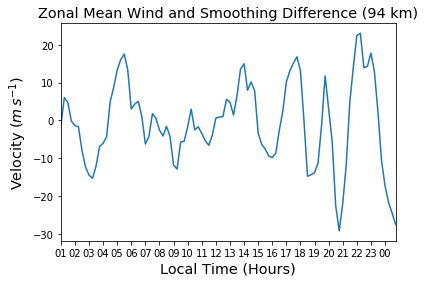

In [165]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

u_diff = u_mean[24, :] - u_smooth
plt.plot(t_plot, u_diff)

plt.title('Zonal Mean Wind and Smoothing Difference (94 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

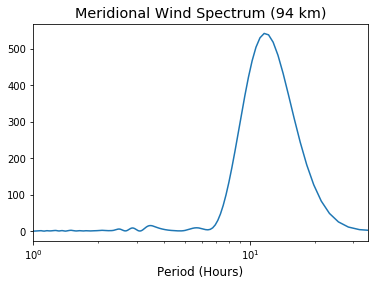

In [166]:
f, a = ss.periodogram(v_mean[24, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[24, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind Spectrum (94 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')


plt.semilogx(period,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

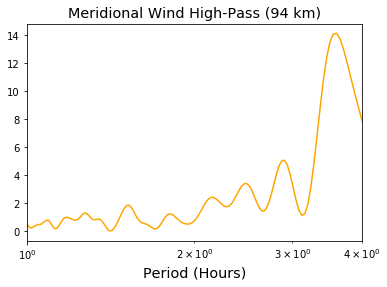

In [167]:
f, a = ss.periodogram(v_mean[24, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[24, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind High-Pass (94 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

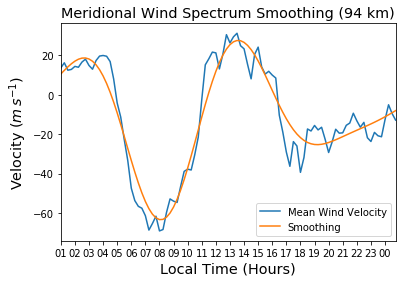

In [168]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Meridional Wind Spectrum Smoothing (94 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, v_mean[24, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, v_smooth, label = 'Smoothing')

plt.legend(loc=4)

[]

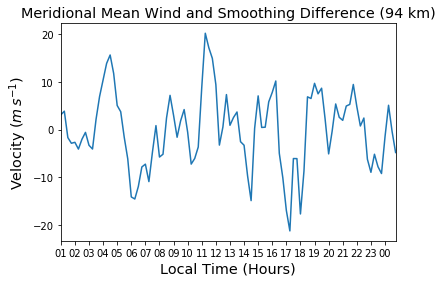

In [169]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

v_diff = v_mean[24, :] - v_smooth
plt.plot(t_plot, v_diff)

plt.title('Meridional Mean Wind and Smoothing Difference (94 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot()

## 96 km Smoothing

In [170]:
period_cutoff = 7*3600  # seconds
win = ss.firwin(len(t_idx), 1./period_cutoff, window='hann', fs=1./(t_idx[1] - t_idx[0]))

u_smooth = ss.correlate(u_mean[28, :], win, mode='same')
v_smooth = ss.correlate(v_mean[28, :], win, mode='same')

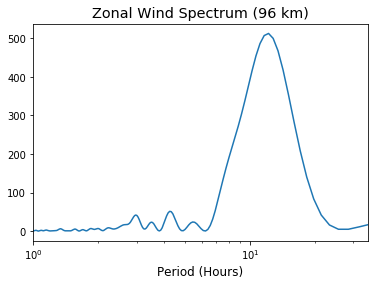

In [171]:
f, a = ss.periodogram(u_mean[28, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[28, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind Spectrum (96 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')

plt.semilogx(period_mean,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

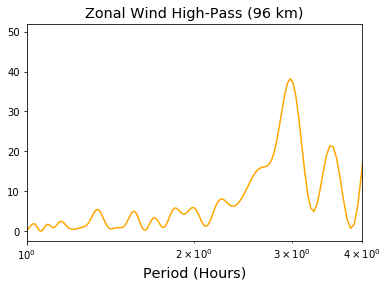

In [172]:
f, a = ss.periodogram(u_mean[28, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

u_diff = u_mean[28, :] - u_smooth
g, b = ss.periodogram(u_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Zonal Wind High-Pass (96 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

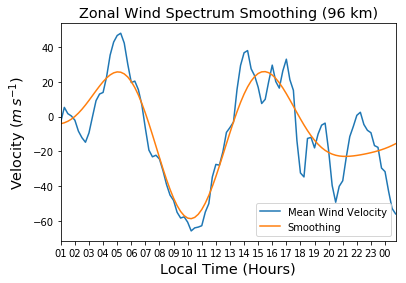

In [173]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Zonal Wind Spectrum Smoothing (96 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, u_mean[28, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, u_smooth, label = 'Smoothing')

plt.legend(loc=4)

Text(0, 0.5, 'Velocity ($m\\/s^{-1}$)')

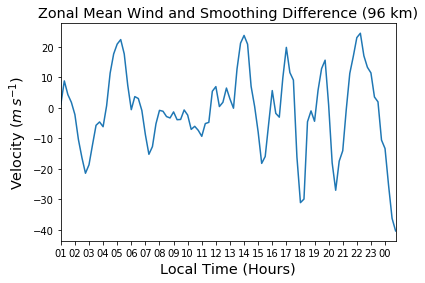

In [174]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

u_diff = u_mean[28, :] - u_smooth
plt.plot(t_plot, u_diff)

plt.title('Zonal Mean Wind and Smoothing Difference (96 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

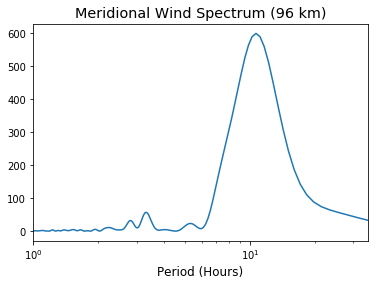

In [175]:
f, a = ss.periodogram(v_mean[28, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[28, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind Spectrum (96 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'large')


plt.semilogx(period,a[1:])

plt.xlim(1,35)
plt.show()

(1, 4)

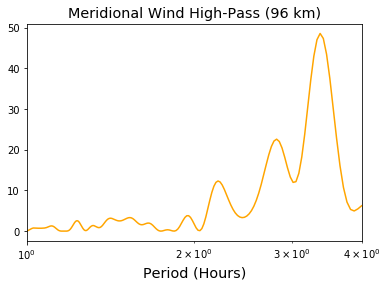

In [176]:
f, a = ss.periodogram(v_mean[28, :], 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_mean = 1 / f[1:] / 3600

v_diff = v_mean[28, :] - v_smooth
g, b = ss.periodogram(v_diff, 1/(t_idx[1] - t_idx[0]), nfft=1024, return_onesided=True, scaling='spectrum')
period_smooth = 1 / g[1:] / 3600

plt.title('Meridional Wind High-Pass (96 km)', size = 'x-large')
plt.xlabel('Period (Hours)', size = 'x-large')

plt.semilogx(period_smooth,b[1:], color='orange') # passing the high frequencies and attenuateing lower frequencies(we are working with period in the plot, so passing the lower period and attenuating the higher period)

plt.xlim(1,4)

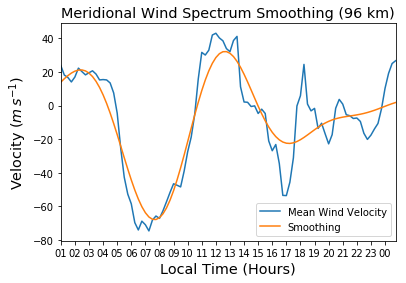

In [177]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

plt.title('Meridional Wind Spectrum Smoothing (96 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot(t_plot, v_mean[28, :], label = 'Mean Wind Velocity')
plt.plot(t_plot, v_smooth, label = 'Smoothing')

plt.legend(loc=4)

[]

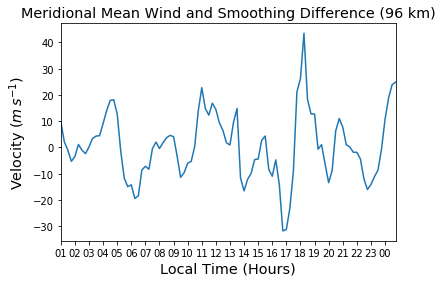

In [178]:
main_tick = mdates.HourLocator()     
main_fmt = mdates.DateFormatter('%H', tz=tz)

ax = plt.gca()
ax.xaxis.set_major_locator(main_tick)
ax.xaxis.set_major_formatter(main_fmt)
ax.set_xlim(min(t_plot), max(t_plot))

v_diff = v_mean[28, :] - v_smooth
plt.plot(t_plot, v_diff)

plt.title('Meridional Mean Wind and Smoothing Difference (96 km)', size='x-large')
plt.xlabel('Local Time (Hours)', size = 'x-large')
plt.ylabel(r'Velocity ($m\/s^{-1}$)', size = 'x-large')

plt.plot()